# Dataset Loading

In [20]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# File reading helpers

from PIL import Image
import pickle
import numpy as np

def load_pickle(filename):
  with open(filename, 'rb') as f:
    return pickle.load(f)

def get_meta(meta_path):
  return load_pickle(meta_path)

def get_depth(depth_path):
  return (np.array(Image.open(depth_path))/1000)

def get_label(label_path):
  return np.array(Image.open(label_path))

def get_point_cloud(depth, intrinsic):
  z = depth
  v, u = np.indices(z.shape)
  uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
  points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]
  return points_viewer

def get_object_point_cloud(image_label, object_id, depth_map, intrinsic):
  # print(np.where(image_label==object_id))
  # print(image_label[327][654])
  image_label[np.where(image_label==object_id)] = 255
  # print(image_label[327][654])
  # print(np.where(image_label==255))
  image_label[np.where(image_label!=255)] = 0
  image_label[np.where(image_label==255)] = 1
  object_depth = depth_map * image_label
  pcd_target = get_point_cloud(object_depth, intrinsic)
  # (H, W, dim) = pcd_target.shape
  # filter out target object point cloud
  # print(pcd_target.shape)
  # print(pcd_target)
  # print((pcd_target[:,0]!=0)|(pcd_target[:,1]!=0)|(pcd_target[:,2]!=0))
  pcd_target = pcd_target.reshape(-1, pcd_target.shape[-1]) # reshape to (H*W, 3)
  pcd_target = pcd_target[(pcd_target[:,0]!=0)|(pcd_target[:,1]!=0)|(pcd_target[:,2]!=0)]
  return pcd_target
# test_pcd_target = get_object_point_cloud(image_label, object_id, depth_map, intrinsic)


In [23]:
# Test data loading helpers
import os

test_split_dir = "./testing_data_pose_filtered/testing_data"
testing_data_root = "./testing_data_pose_filtered/testing_data"
testing_data_dir = "./testing_data_pose_filtered/testing_data/v2.2"

def get_test_split_files(split_name):
    with open(os.path.join(test_split_dir, f"{split_name}.txt"), 'r') as f:
        # for line in f:
        #   print(line)
        #   if line.strip():
        #     print(testing_data_dir)
        #     print(line.strip())
        prefixIds = [line.strip() for line in f if line.strip()]
        prefix = [os.path.join(testing_data_dir, line) for line in prefixIds]
        # print(prefixIds)
        # print(prefix)
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta, prefixIds


test_rgb_files, test_depth_files, test_label_files, test_meta_files, test_prefix_ids = get_test_split_files('test')

In [24]:
# Rephase training objects point clouds and poses into {scene}_{object_id}.npz
!mkdir /content/testing_data_pose_filtered/testing_data/test_npy
import numpy as np
import time
from tqdm import tqdm

roundDown = 0

def save_object_info_array(train_rgb_files, train_depth_files, train_label_files, train_meta_files, train_prefix_ids, save_dir="/content/training_data_filtered/training_data/train_npy"):
  stt = time.time()
  infoPaths = []
  # roundUp = 400
  roundUp = len(train_rgb_files)
  for i in tqdm(range(roundDown, roundUp)):
    meta_dict = get_meta(train_meta_files[i])
    object_dict = {}

    # Fetch scene id
    prefix_id = train_prefix_ids[i]
    object_dict["prefix_id"] = prefix_id
    if prefix_id.startswith('1'):
      object_dict["scene"] = 0
    else:
      object_dict["scene"] = 1

    label_map = get_label(train_label_files[i])
    depth_map = get_depth(train_depth_files[i])
    intrinsic = meta_dict['intrinsic']
    object_ids = meta_dict['object_ids']
    for j in range(len(object_ids)):
      # Fetch object id and pose
      object_id = object_ids[j]
      object_dict["id"] = object_id
      # object_dict["pose"] = meta_dict["poses_world"][object_id]
      # Fetch point cloud and colors (TODO)
      object_pcd = get_object_point_cloud(label_map.copy(), object_id, depth_map, intrinsic)
      object_dict["points"] = object_pcd
      save_path = os.path.join(save_dir, '{}-{:02d}.npy'.format(prefix_id, object_id))
      np.save(save_path, object_dict)
      infoPaths.append(save_path)
  end = time.time()
  print("Object info array saving finished! Taking {}".format(end-stt))
  return infoPaths

object_file_paths_test = save_object_info_array(test_rgb_files, test_depth_files, test_label_files, test_meta_files, test_prefix_ids, save_dir="/content/testing_data_pose_filtered/testing_data/test_npy")



mkdir: cannot create directory ‘/content/testing_data_pose_filtered/testing_data/test_npy’: File exists


100%|██████████| 200/200 [03:04<00:00,  1.08it/s]

Object info array saving finished! Taking 184.42481637001038


In [28]:
# Load object meta-data
import pandas as pd
import numpy as np

object_models_file = "/content/testing_data_pose_filtered/testing_data/objects_v1.csv"
object_models_info = pd.read_csv(object_models_file)

In [29]:
"""Metric and visualization."""

def compute_rre(R_est: np.ndarray, R_gt: np.ndarray):
    # relative rotation error (RRE)
    rre = np.arccos(np.clip(0.5 * (np.trace(R_est.T @ R_gt) - 1), -1.0, 1.0))
    return rre


def compute_rte(t_est: np.ndarray, t_gt: np.ndarray):
    # relative translation error (RTE)
    rte = np.linalg.norm(t_est - t_gt) # Resembling MSE loss
    return rte




In [30]:
# Data loader definition
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
import numpy as np
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import math
import shutil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PoseDataset(Dataset):
    def __init__(self, files, root, n_points=256, is_test=False) -> None:
        super().__init__()
        self.files = files
        self.root = root
        self.n_points = n_points
        self.is_test = is_test
        np.random.shuffle(self.files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        result = {}
        npz = np.load(os.path.join(self.root, self.files[index]), allow_pickle=True)
        npz = npz.ravel()[0]
        # print(npz)
        # print(type(npz))
        object_id = npz["id"]
        scene = npz["scene"]
        points = npz["points"]
        # colors = npz["colors"]

        if len(points) == 0:
            points = np.zeros((self.n_points, 3))
            # colors = np.zeros((self.n_points, 3))
        if len(points) < self.n_points:
            idx = np.random.choice(len(points), self.n_points, replace=True)
            points = points[idx]
            # colors = colors[idx]
        else:
            idx = np.random.choice(len(points), self.n_points, replace=False)
            points = points[idx]
            # colors = colors[idx]
        result["object_id"] = torch.tensor(object_id, dtype=torch.long)
        result["scene"] = torch.tensor(scene, dtype=torch.long)
        result["points"] = torch.tensor(points.T, dtype=torch.float32)
        # result["colors"] = torch.tensor(colors.T, dtype=torch.float32)
        if not self.is_test:
          pose = npz["pose"]
          result["pose"] = torch.tensor(pose, dtype=torch.float32)
        else:
          result["prefix_id"] = npz["prefix_id"]
        return result

In [32]:
# garbage collection to avoid CUDA memory explosion =_=
import gc
gc.collect()

0

# PointNetDense loading

In [33]:
# Test data loading helpers
import os

test_split_dir = "./testing_data_pose_filtered/testing_data"
testing_data_root = "./testing_data_pose_filtered/testing_data"
testing_data_dir = "./testing_data_pose_filtered/testing_data/v2.2"

def get_test_split_files(split_name):
    with open(os.path.join(test_split_dir, f"{split_name}.txt"), 'r') as f:
        prefixIds = [line.strip() for line in f if line.strip()]
        prefix = [os.path.join(testing_data_dir, line) for line in prefixIds]
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta, prefixIds


test_rgb_files, test_depth_files, test_label_files, test_meta_files, test_prefix_ids = get_test_split_files('test')

In [35]:
# PointNetDense network (saved)
from torch.autograd import Variable
import torch

def rot_6d(x, y):
    # Gram-schmidt process to get the rotation matrix
    x = F.normalize(x, dim=-1)
    y = y - x * (x * y).sum(-1, keepdims=True)
    y = F.normalize(y, dim=-1)
    z = torch.cross(x, y, -1)
    return torch.stack([x, y, z], dim=-1)

class STNkd(nn.Module):
    def __init__(self, k_input=32, k_output=32*32, n_points=256, spread_points=False):
        self.n_points = n_points
        self.spread_points = spread_points
        self.k_input = k_input
        self.k_output = k_output

        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k_input, 64, 1) # feature extractors
        self.conv2 = torch.nn.Conv1d(64, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 512, 1)
        self.bnConv1 = nn.BatchNorm1d(64)
        self.bnConv2 = nn.BatchNorm1d(256)
        self.bnConv3 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()

        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        if self.spread_points:
          self.fc4 = nn.Linear(128, k_output*n_points)
        else:
          self.fc4 = nn.Linear(128, k_output)
        self.bnDense2 = nn.BatchNorm1d(256)
        self.bnDense3 = nn.BatchNorm1d(128)

        # weight initializations
        for net in [
            self.conv1,
            self.conv2,
            self.conv3,
            self.fc2,
            self.fc3,
            self.fc4
        ]:
            torch.nn.init.xavier_uniform_(net.weight)

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bnConv1(self.conv1(x)))
        x = F.relu(self.bnConv2(self.conv2(x)))
        x = F.relu(self.bnConv3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 512)

        x = F.relu(self.bnDense2(self.fc2(x)))
        x = F.relu(self.bnDense3(self.fc3(x)))
        x = self.fc4(x)

        if self.spread_points:
          x = x.view(-1, self.k_output, self.n_points)
        return x

class PointNet(nn.Module):
    def __init__(self, global_feature_size=81, n_points=256): # global feature = object id (size=79) + scene id (size=2)
        super(PointNet, self).__init__()
        self.n_points = n_points
        self.global_feature_size = global_feature_size
        self.stn3d_input_feat = STNkd(k_input=3, k_output=3*3, n_points=self.n_points, spread_points=True)
        self.conv1 = torch.nn.Conv1d(3*3, 64, 1) # local feature extraction layers
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 256, 1)
        self.conv4 = torch.nn.Conv1d(256, 512, 1)
        self.conv5 = torch.nn.Conv1d(512, 1024, 1)
        self.bnConv1 = nn.BatchNorm1d(64)
        self.bnConv2 = nn.BatchNorm1d(128)
        self.bnConv3 = nn.BatchNorm1d(256)
        self.bnConv4 = nn.BatchNorm1d(512)
        self.bnConv5 = nn.BatchNorm1d(1024)

        self.branch1 = torch.nn.Linear(global_feature_size, 256) # global feature extraction layers
        self.bnBranch1 = nn.BatchNorm1d(256)
        self.branch2 = torch.nn.Linear(256, 1024) # global feature extraction layers
        self.bnBranch2 = nn.BatchNorm1d(1024)
        self.dense2_r = torch.nn.Linear(2048, 1024) # inference layers
        self.dense2_t = torch.nn.Linear(2048, 1024)
        self.bnDense2_r = nn.BatchNorm1d(1024)
        self.bnDense2_t = nn.BatchNorm1d(1024)
        self.dense3_r = torch.nn.Linear(1024, 512)
        self.dense3_t = torch.nn.Linear(1024, 512)
        self.bnDense3_r = nn.BatchNorm1d(512)
        self.bnDense3_t = nn.BatchNorm1d(512)
        self.dense4_r = torch.nn.Linear(512, 256)
        self.dense4_t = torch.nn.Linear(512, 256)
        self.bnDense4_r = nn.BatchNorm1d(256)
        self.bnDense4_t = nn.BatchNorm1d(256)
        self.dense5_r = torch.nn.Linear(256, 128)
        self.dense5_t = torch.nn.Linear(256, 128)
        self.bnDense5_r = nn.BatchNorm1d(128)
        self.bnDense5_t = nn.BatchNorm1d(128)
        self.dense6_r = torch.nn.Linear(128, 6) # output layer for rotation
        self.dense6_t = torch.nn.Linear(128, 3) # output layer for translation

        # weight initializations
        for net in [
            # self.conv0,
            self.conv1,
            self.conv2,
            self.conv3,
            self.conv4,
            self.conv5,
            self.branch1,
            self.branch2,
            self.dense2_r,
            self.dense2_t,
            self.dense3_r,
            self.dense3_t,
            self.dense4_r,
            self.dense4_t,
            self.dense5_r,
            self.dense5_t,
            self.dense6_r,
            self.dense6_t
        ]:
            torch.nn.init.xavier_uniform_(net.weight)

    def forward(self, x, label, scene):
        points = x[:, :3]  # batch_size, 3, n_points
        # colors = x[:, 3:]

        # normalize to [-1,1] centered at (0,0,0)
        mins = points.min(dim=2, keepdim=True).values
        maxs = points.max(dim=2, keepdim=True).values
        center = (mins + maxs) / 2
        half_extents = (maxs - mins) / 2
        longest = half_extents.max(dim=1, keepdim=True).values.clamp(
            min=1e-3
        )
        points = (points - center) / longest

        # pcd feature extractions
        x = points

        # initial transform with spatial transformer
        x = self.stn3d_input_feat(x)
        x = F.relu(self.bnConv1(self.conv1(x)))
        x = F.relu(self.bnConv2(self.conv2(x)))
        x = F.relu(self.bnConv3(self.conv3(x)))
        x = F.relu(self.bnConv4(self.conv4(x)))
        x = F.relu(self.bnConv5(self.conv5(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        # global feature extractions
        globalFeature = torch.cat((label, scene), dim=1)
        globalFeature = self.bnBranch1(self.branch1(globalFeature))
        globalFeature = self.bnBranch2(self.branch2(globalFeature))

        # concatenate local and global features, and transform using a transformer
        x = torch.cat((x, globalFeature), dim=1)
        x_rot = x
        x_tran = x_rot.clone()

        # infer rotation
        x_rot = F.relu(self.bnDense2_r(self.dense2_r(x_rot)))
        x_rot = F.relu(self.bnDense3_r(self.dense3_r(x_rot)))
        x_rot = F.relu(self.bnDense4_r(self.dense4_r(x_rot)))
        x_rot = F.relu(self.bnDense5_r(self.dense5_r(x_rot)))
        x_rot = self.dense6_r(x_rot)
        x_rot = rot_6d(x_rot[..., 0:3], x_rot[..., 3:6]) # fetch output rotation matrix

        x_tran = F.relu(self.bnDense2_t(self.dense2_t(x_tran)))
        x_tran = F.relu(self.bnDense3_t(self.dense3_t(x_tran)))
        x_tran = F.relu(self.bnDense4_t(self.dense4_t(x_tran)))
        x_tran = F.relu(self.bnDense5_t(self.dense5_t(x_tran)))
        x_tran = self.dense6_t(x_tran)
        x_tran = x_tran * longest.view(-1, 1) + center.view_as(x_tran) # scale back and un-center (batch_size, 3), to get translation vector
        return x_tran, x_rot


In [36]:
# inference with pointnet, to get initial ICP matrices
import numpy as np
import shutil
import json

test_batch_size = 512
test_num_workers = 4

# sel_epoch = 24
sel_epoch = 20 # choose the 20th epoch's model. Since other ones may overfit
model_path = "/content/model_save_3/model_{}.pth".format(sel_epoch)
model = torch.load(model_path)
model.eval()
poses = {}
test_files_path = "/content/testing_data_pose_filtered/testing_data/test_npy"
test_data = PoseDataset(os.listdir(test_files_path), test_files_path, is_test=True)
loader_test = DataLoader(test_data, batch_size=test_batch_size, num_workers=test_num_workers)

def get_pose_matrix(rot, tr):
  T = np.identity(4)
  T[:3, :3] = rot
  T[:3, 3] = tr
  return T

def load_json(path):
  f = open(path)
  data = json.load(f)
  return data

def dump_json(sample, path):
  with open(path, 'w') as fp:
    json.dump(sample, fp)
  return 0

for data in tqdm(loader_test):
    # print(data)
    object_id = data["object_id"].to(device)
    points = data["points"].to(device)
    # colors = data["colors"].to(device)
    scene = data["scene"].to(device)
    prefix_id = data["prefix_id"]

    pred_trans, pred_rot = model(
        torch.cat([points], dim=1), F.one_hot(object_id, 79).float(), F.one_hot(scene, 2).float()
        # torch.cat([points, colors], dim=1), F.one_hot(object_id, 79).float()
    )

    for j in range(pred_trans.shape[0]):
      tr, rot = pred_trans[j, ...], pred_rot[j, ...]
      prefix = prefix_id[j]
      id = object_id[j]
      T = get_pose_matrix(rot.detach().cpu().numpy(), tr.detach().cpu().numpy())
      if prefix not in poses.keys():
        poses[prefix] = {"poses_world": [None]*79}
      poses[prefix]["poses_world"][id] = T.tolist()

dump_json(poses, "result_test_pointnet.json")
# shutil.copy("result_test_pointnet.json", "/content/drive/MyDrive/model_save_3/")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


0

# ICP+PointNetDense inference

In [37]:
!pip install open3d trimesh
!pip install pycollada

In [38]:
"""Definitions of hyper-parameters"""
import open3d as o3d

def load_json(path):
  f = open(path)
  data = json.load(f)
  return data

icp_global_voxel_size = 0.03
icp_dist_threshold = 5
init_random_time = 20
max_preproc_nn_normal = 50
max_preproc_nn_fpfh = 100
tgSrcFactor = 1.3
dist_voxel_factor = 3
fps_dnsamp_factor = 2000
geodDistFrac = 0.3
cdistFrac = 0.1
heavy_dnsamp_frac = 9/14
# heavy_dnsamp_frac = 1/2 # exp 7
# heavy_dnsamp_frac = 5/14 # exp 8
icp_relative_fitness = 0.00001
icp_relative_rmse = 0.00001
icp_max_iteration = 500
light_heavy_dnsamp_vxsize_ratio = 0.001
# light_heavy_dnsamp_vxsize_ratio = 0.1
ransac_max_iteration = 10000000
ransac_max_validation = 0.99999

init_pointnet = load_json("result_test_pointnet.json")
print(init_pointnet["1-1-1"])

{'poses_world': [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, [[-0.025735948234796524, -0.9996639490127563, -0.003105234121903777, 0.05752333626151085], [0.9996676445007324, -0.025740424171090126, 0.0014045193092897534, 0.029199060052633286], [-0.0014839773066341877, -0.0030680554918944836, 0.999994158744812, -0.006154179573059082], [0.0, 0.0, 0.0, 1.0]], None, None, None, [[0.8071111440658569, 0.590385377407074, 0.004093529190868139, 0.08922518789768219], [-0.5903828144073486, 0.8071210384368896, -0.0019382352475076914, -0.03648045286536217], [-0.004448279272764921, -0.000852378027047962, 0.9999897480010986, 0.07454681396484375], [0.0, 0.0, 0.0, 1.0]], None, None, None, None, None, None, None, None, [[-0.007069979794323444, 0.9999715089797974, -0.0026460548397153616, 0.1350480020046234], [-0.9999440908432007, -0.0070489146

In [60]:
# Load the canonical-space object point clouds
import trimesh
import os
import pandas as pd

def fps_downsample(points, number_of_points_to_sample):
  selected_points = np.zeros((number_of_points_to_sample, 3))
  dist = np.ones(points.shape[0]) * np.inf # distance to the selected set
  for i in tqdm(range(number_of_points_to_sample)):
      # pick the point with max dist
      idx = np.argmax(dist)
      selected_points[i] = points[idx]
      dist_ = ((points - selected_points[i]) ** 2).sum(-1)
      dist = np.minimum(dist, dist_)
  return selected_points

object_models_info = pd.read_csv(object_models_file)
object_models_name = object_models_info["object"].to_list()
object_models_location = object_models_info["location"].to_list()
object_models_num = len(object_models_name)

object_models = {}
for object_name, object_mesh_dir in zip(object_models_name, object_models_location):
  object_mesh_path = os.path.join(object_mesh_dir, "visual_meshes", "visual.dae")
  object_mesh = trimesh.exchange.dae.load_collada(object_mesh_path)
  mesh_name = object_mesh['graph'][0]['geometry']
  object_models[object_name] = object_mesh['geometry'][mesh_name]['vertices']


In [40]:
from sklearn.neighbors import NearestNeighbors

# Naive ICP implementations
def get_Tr(rot, tr):
    Tr = np.eye(4)
    Tr[:3, :3] = rot
    Tr[:3, 3] = tr
    return Tr


def NearestNei(src, dst):
    # Find nearest neighbour between src and dst pcds
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()

def get_RT(x, y, scale_tr=True):
    # Umeyama's alignment to get R, t
    assert x.shape == y.shape
    m, n = x.shape
    mean_x = x.mean(axis=1)
    mean_y = y.mean(axis=1)
    sigma_x = 1.0 / n * (np.linalg.norm(x - mean_x[:, np.newaxis])**2)
    
    # covariance matrix computations
    outer_sum = np.zeros((m, m))
    for i in range(n):
        outer_sum += np.outer((y[:, i] - mean_y), (x[:, i] - mean_x))
    cov_xy = np.multiply(1.0 / n, outer_sum)

    # svd
    u, d, v = np.linalg.svd(cov_xy)
    s = np.eye(m)
    if np.linalg.det(u) * np.linalg.det(v) < 0.0:
        s[m - 1, m - 1] = -1

    # Fetch rotation from svd
    r = u.dot(s).dot(v)

    # Fetch scale and translation from svd
    c = 1 / sigma_x * np.trace(np.diag(d).dot(s)) if scale_tr else 1.0
    t = mean_y - np.multiply(c, r.dot(mean_x))
    return r, t, c


def naive_icp(source, target, max_iterations=500, tolerance=1e-7, tr_scale_init=1, init_transformation=None):
    # Perform ICP with translation scaling
    src = np.copy(source.T)
    dst = np.copy(target.T)
    if init_transformation is not None:
        r = init_transformation[:3, :3]
        t = init_transformation[:3, 3][:, np.newaxis]
        src = np.multiply(tr_scale_init, np.dot(r, src)) + t
    prev_error = 0

    for i in range(max_iterations):
        distances, indices = NearestNei(src.T,dst.T) # re-assign Nearest Neighbours
        rotation, translation, scale = get_RT(src, dst[:,indices], scale_tr=False) # Re-fit rotation, translation, and scales
        src = np.multiply(scale, rotation.dot(src)) + translation[:,np.newaxis]
        mean_error = np.mean(distances)
        # break if absolute error reached
        if np.abs(prev_error-mean_error) < tolerance:
            rotation, translation, scale = get_RT(src, dst[:,indices], scale_tr=True)
            src = np.multiply(scale, rotation.dot(src)) + translation[:,np.newaxis]
            break
        prev_error = mean_error
    # Get final transformation
    rotation, translation, scale = get_RT(source.T, src, scale_tr=True)
    return rotation, translation, scale


In [41]:
# ICP implementations with pointnet init
import numpy as np
from sklearn.neighbors import NearestNeighbors

def preprocess_point_cloud(source, target, voxel_size, tgSrcFactor=tgSrcFactor, max_nn_normal=max_preproc_nn_normal):
    # down-sample source point cloud.
    # Here uses farthest-point sampling since it performs better than voxel down-sampling
    size_factor = len(source.points) / len(target.points)
    if (size_factor >= 1):
      # src_pcd_down = half_voxel_dnsample(source, voxel_size=voxel_size)
      src_pcd_down = source.farthest_point_down_sample(len(target.points))
      tg_pcd_down = target
    else:
      # tg_pcd_down = tg_pcd_down.farthest_point_down_sample(len(source.points))
      src_pcd_down = source
      tg_pcd_down = target
    return src_pcd_down, tg_pcd_down

def prepare_dataset(voxel_size, source, target):
    # Since no RANSAC init needed. We just need to down-sample source and target point clouds
    source_down, target_down = preprocess_point_cloud(source, target, voxel_size)
    return source_down, target_down

def icp_init_with_pointnet(source_points, target_points, init):
  # ICP with PointNetDense initialized
  target_scale = np.max(target_points,axis=0)-np.min(target_points,axis=0)
  source_scale = np.max(source_points,axis=0)-np.min(source_points,axis=0)
  if (0 in source_scale):
    tr_scale_init = 1
  else:
    tr_scale_init = np.mean(target_scale/source_scale)
  # run inited ICP
  rot, tr, _ = naive_icp(source_points, target_points, tr_scale_init=tr_scale_init, init_transformation=init)
  return get_Tr(rot, tr)

def get_icp_with_pointnet_init(source_pcd, target_pcd, voxel_size=icp_global_voxel_size, init=np.eye(4)):
  # Perform ICP with PointNetDense initialization on source pcd
  source_pcd_o3d, target_pcd_o3d = o3d.geometry.PointCloud(), o3d.geometry.PointCloud()
  source_pcd_o3d.points = o3d.utility.Vector3dVector(source_pcd)
  target_pcd_o3d.points = o3d.utility.Vector3dVector(target_pcd)
  source_down, target_down = prepare_dataset(voxel_size, source_pcd_o3d, target_pcd_o3d)
  result_icp = icp_init_with_pointnet(np.asarray(source_down.points), np.asarray(target_down.points), init=init)
  return result_icp



In [47]:
# ICP helpers
import numpy as np
import json

def load_pickle(filename):
  with open(filename, 'rb') as f:
    return pickle.load(f)

def dump_json(sample, path):
  with open(path, 'w') as fp:
    json.dump(sample, fp)
  return 0

def load_json(path):
  f = open(path)
  data = json.load(f)
  return data

def get_point_cloud(depth, intrinsic):
  z = depth
  v, u = np.indices(z.shape)
  uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
  points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]
  return points_viewer

def get_object_point_cloud(test_image_label, object_id, test_depth, intrinsic):
  test_image_label[np.where(test_image_label==object_id)] = 255
  test_image_label[np.where(test_image_label!=255)] = 0
  test_image_label[np.where(test_image_label==255)] = 1
  test_object_depth = test_depth * test_image_label
  test_pcd_target = get_point_cloud(test_object_depth, intrinsic)
  test_pcd_target = test_pcd_target.reshape(-1, test_pcd_target.shape[-1]) # reshape to (H*W, 3)
  test_pcd_target = test_pcd_target[(test_pcd_target[:,0]!=0)|(test_pcd_target[:,1]!=0)|(test_pcd_target[:,2]!=0)]
  return test_pcd_target

def get_meta(meta_path):
  return load_pickle(meta_path)

def get_depth(depth_path):
  return (np.array(Image.open(depth_path))/1000)

def get_label(label_path):
  return np.array(Image.open(label_path))

def getTransPcd(source_pcd, T):
  return source_pcd @ T[:3, :3].T + T[:3, 3]

def getRotationGeoDist(r, rgt):
  return np.arccos(1/2 * (np.trace(rgt @ r.T) - 1))

def getTranslationDist(t, tgt):
  return np.norm(t-tgt)

def o3dvis(pts):
  o3d.visualization.draw_geometries([pts_to_o3d_pcd(pt) for pt in pts])
  return 0

def pts_to_o3d_pcd(pts):
  """Transform to o3d pcd"""
  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(pts)
  return pcd

def o3d_Vec_to_o3d_pcd(pts):
  """Transform to o3d pcd"""
  pcd = o3d.geometry.PointCloud()
  pcd.points = pts
  return pcd

def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / (sigma + 1.0e-16)



In [61]:
# Start ICP estimation for all test data
!mkdir test_outputs_pointnet_icp_4
import numpy as np
from tqdm import tqdm
import os
import copy

# Flag for continuing from previous steps
ctu = True
ctu_variant, ctu_index = 0, 0
if ctu:
  ctu_variant, ctu_index = "2-50-1", 149

# Output resulting dictionary
dataset_type = "test"
output_dir = "./{}_outputs_pointnet_icp_4".format(dataset_type)
test_size = 200

# pointnet initializer loading
init_dict = load_json("/content/result_test_pointnet.json")

# For each object at each testing data: Get scene object's point cloud (as target pcd)
result_dict = {}
if ctu:
  json_path = os.path.join(output_dir, "result_till_{}_index_{}.json".format(ctu_variant, ctu_index))
  result_dict = load_json(json_path)
print(test_depth_files)
print(test_meta_files)
print(test_label_files)
print(test_prefix_ids)

# for test_depth_path, test_meta_path, test_label_path, test_prefix_id in tqdm(zip(test_depth_files, test_meta_files, test_label_files, test_prefix_ids)):
for i in range(ctu_index, test_size):
  if (i % 10 == 0):
    print("Auto-uploading test outputs to cloud at epoch {}".format(i))
    !cp -r /content/test_outputs_pointnet_icp_4 /content/drive/MyDrive/
  test_depth_path, test_meta_path, test_label_path, test_prefix_id = test_depth_files[i], test_meta_files[i], test_label_files[i], test_prefix_ids[i]
  print("Test data id {}".format(test_prefix_id))
  test_meta, test_depth, test_seg_label = get_meta(test_meta_path), get_depth(test_depth_path), get_label(test_label_path)   # convert from mm to m
  intrinsic = test_meta["intrinsic"]
  extrinsic = test_meta["extrinsic"]
  inv_extrinsic = np.linalg.inv(extrinsic)
  scales = test_meta["scales"]
  result_dict[test_prefix_id] = {}
  result_dict[test_prefix_id]["poses_world"] = [None] * object_models_num
  for object_id, object_name in zip(test_meta["object_ids"], test_meta["object_names"]):
    print("Object id {}, name {}".format(object_id, object_name))
    if (np.sum(test_seg_label==object_id) == 0):
      print("Object not found at scene.")
      continue
    test_image_label = test_seg_label.copy()

    # Reconstruct pcd from depth map and image label
    test_pcd_target = get_object_point_cloud(test_image_label, object_id, test_depth, intrinsic)

    # Fetch source point cloud from model dictionary
    test_pcd_source = object_models[object_name]
    test_pcd_source *= scales[object_id] # scale the model pcd using factors
    if (not test_pcd_source.any()):
      print("Model pcd are all origins, meaning that memory data are lost. Re-run the jupyter notebook!")
      continue

    # ICP+PointNetDense to get pose
    init = init_dict[test_prefix_id]["poses_world"][object_id]
    init = np.asarray(init)
    init_cam = extrinsic @ init # map to camera frame
    T = get_icp_with_pointnet_init(test_pcd_source, test_pcd_target, init=init_cam)
    T_world = inv_extrinsic @ T # Transform to world coordinate

    # Simply take PointNet's rotation and ICP's translation as results
    T_world[:3, :3] = init[:3, :3]

    # update resulting dictionary with object id and pose list
    result_dict[test_prefix_id]["poses_world"][object_id] = T_world.tolist()
  if (((i+1)%10)==0):
    output_name = "result_till_{}_index_{}.json".format(test_prefix_id, i)
    dump_json(result_dict, os.path.join(output_dir, output_name))

print("Test result:")
print(result_dict)
print(len(result_dict))



# Output resulting dictionary
output_name = "result_pointnet_icp_4.json"
dump_json(result_dict, os.path.join(output_dir, output_name))
!cp /content/test_outputs_pointnet_icp_4/result_pointnet_icp_1.json /content/drive/MyDrive/outputs
!cp -r /content/test_outputs_pointnet_icp_4 /content/drive/MyDrive/




mkdir: cannot create directory ‘test_outputs_pointnet_icp_4’: File exists
['./testing_data_pose_filtered/testing_data/v2.2/1-1-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-2-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-3-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-4-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-5-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-6-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-7-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-8-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-9-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-10-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-11-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.2/1-12-1_depth_kinect.png', './testing_data_pose_filtered/testing_data/v2.

In [62]:
!cp /content/test_outputs_pointnet_icp_4/result_pointnet_icp_4.json ./

# Visualizations

In [50]:
# visualization helpers
import torch
import numpy as np
from pathlib import Path
import numpy as np
import cv2

VERTEX_COLORS = [
    (0, 0, 0),
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
    (1, 1, 1),
    (0, 1, 1),
    (1, 0, 1),
    (1, 1, 0),
]


def get_corners():
    """Get 8 corners of a cuboid. (The order follows OrientedBoundingBox in open3d)
        (y)
        2 -------- 7
       /|         /|
      5 -------- 4 .
      | |        | |
      . 0 -------- 1 (x)
      |/         |/
      3 -------- 6
      (z)
    """
    corners = np.array(
        [
            [0.0, 0.0, 0.0],
            [1.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
            [0.0, 0.0, 1.0],
            [1.0, 1.0, 1.0],
            [0.0, 1.0, 1.0],
            [1.0, 0.0, 1.0],
            [1.0, 1.0, 0.0],
        ]
    )
    return corners - [0.5, 0.5, 0.5]


def get_edges(corners):
    assert len(corners) == 8
    edges = []
    for i in range(8):
        for j in range(i + 1, 8):
            if np.sum(corners[i] == corners[j]) == 2:
                edges.append((i, j))
    assert len(edges) == 12
    return edges



def getRotationGeoDist(r, rgt):
    return torch.arccos(1/2 * (torch.trace(rgt @ r.transpose(0,2,1)) - 1))

def getTranslation(t, tgt):
  return np.norm(t-tgt)

def draw_projected_box3d(
    image, center, size, rotation, extrinsic, intrinsic, color=(0, 1, 0), thickness=1
):
    """Draw a projected 3D bounding box on the image.

    Args:
        image (np.ndarray): [H, W, 3] array.
        center: [3]
        size: [3]
        rotation (np.ndarray): [3, 3]
        extrinsic (np.ndarray): [4, 4]
        intrinsic (np.ndarray): [3, 3]
        color: [3]
        thickness (int): thickness of lines
    Returns:
        np.ndarray: updated image.
    """
    corners = get_corners()  # [8, 3]
    edges = get_edges(corners)  # [12, 2]
    corners = corners * size
    corners_world = corners @ rotation.T + center
    corners_camera = corners_world @ extrinsic[:3, :3].T + extrinsic[:3, 3]
    corners_image = corners_camera @ intrinsic.T
    uv = corners_image[:, 0:2] / corners_image[:, 2:]
    uv = uv.astype(int)

    for (i, j) in edges:
        cv2.line(
            image,
            (uv[i, 0], uv[i, 1]),
            (uv[j, 0], uv[j, 1]),
            tuple(color),
            thickness,
            cv2.LINE_AA,
        )

    for i, (u, v) in enumerate(uv):
        cv2.circle(image, (u, v), radius=1, color=VERTEX_COLORS[i], thickness=1)
    return image

In [45]:
!cp /content/drive/MyDrive/test_outputs_pointnet_icp_2/result_pointnet_icp_2.json ./

{'1-1-1': {'poses_world': [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, [[-0.183109313249588, -0.9830880761146545, 0.0029633413068950176, 0.09058931353097405], [0.9830566644668579, -0.1831275373697281, -0.007988241501152515, -0.019576065318034297], [0.008395814336836338, 0.0014504111604765058, 0.999963641166687, 0.022743669811540634], [0.0, 0.0, 0.0, 1.0]], None, None, None, [[0.9165193438529968, 0.39995887875556946, 0.005027718376368284, 0.1105329807914936], [-0.39998137950897217, 0.9165107607841492, 0.004785842727869749, 0.0016060646954505486], [-0.00269381795078516, -0.006397310644388199, 0.9999759793281555, 0.06792804981301537], [0.0, 0.0, 0.0, 1.0]], None, None, None, None, None, None, None, None, [[-0.19495344161987305, 0.9808124899864197, -0.00029833195731043816, -0.04082392534302848], [-0.9807690978050232, -0.194941

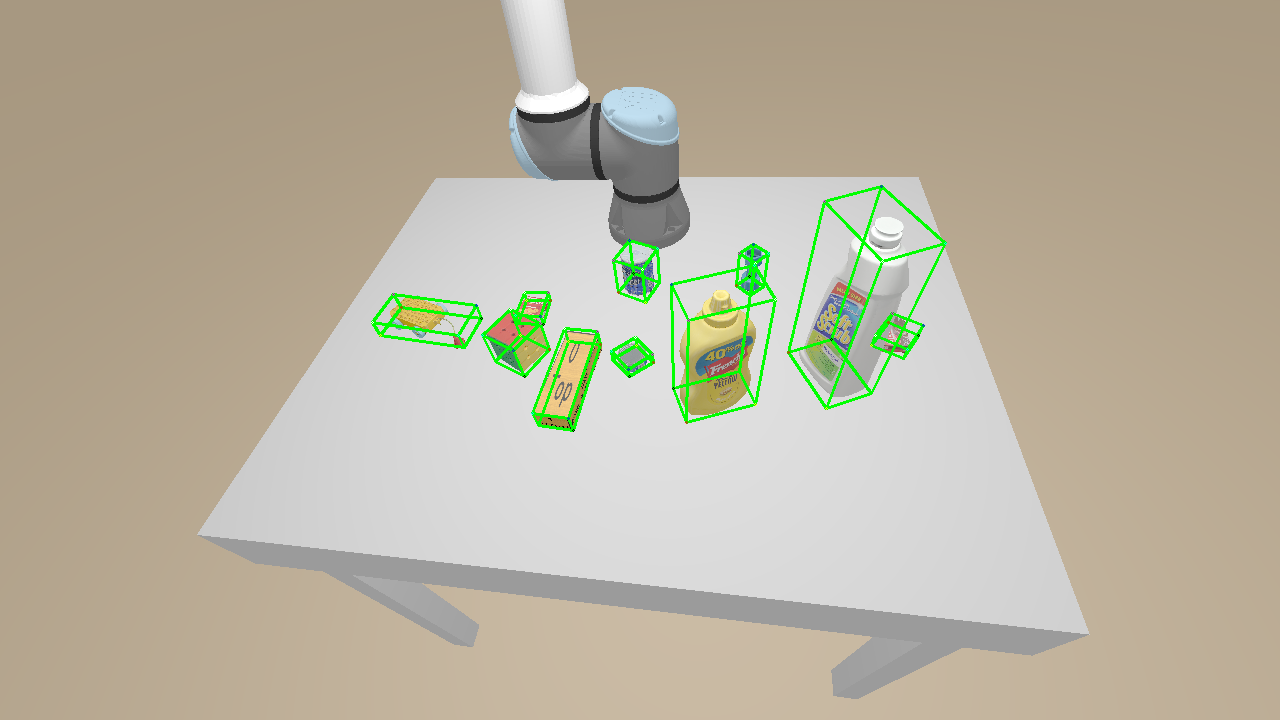

In [64]:
# visualize poses on test images
prefix = "2-14-1"

meta_path = "/content/testing_data_pose_filtered/testing_data/v2.2/{}_meta.pkl".format(prefix)
meta = get_meta(meta_path)

rgb_path = "/content/testing_data_pose_filtered/testing_data/v2.2/{}_color_kinect.png".format(prefix)
rgb = np.array(Image.open(rgb_path)) / 255   # convert 0-255 to 0-1


poses = load_json("/content/result_pointnet_icp_2.json")
print(poses)
boxed_image = np.array(rgb)
poses_world = np.array([poses[prefix]['poses_world'][idx] for idx in meta['object_ids']])
box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])
for i in range(len(poses_world)):
    draw_projected_box3d(
        boxed_image, poses_world[i][:3,3], box_sizes[i], poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
        thickness=2)

Image.fromarray((boxed_image * 255).astype(np.uint8))